# Models

The objective of this project is a binary classification task of distinguishing between posts about Language Technology and posts about Neuro Linguistic Programming.

In this notebook, models with different features and hyperpameters will be evaluated, both on the dataset on Language Tech and Neuro Linguistic Programming (df), and also how well it generalises to the tangential datasets of Deep Learning and Hypnosis (dldf).

Logistic Regression, Naive Bayes, K Nearest Neighbors, Random Forest, Support Vector Machine and XGBoost classifiers will be tried out, each with both the Count Vectorizer and Tfidf Vectorizer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score as ROC, roc_curve
from sklearn.pipeline import Pipeline
import xgboost as xgb

## Load Data

In [2]:
df = pd.read_csv('../data/clean/nl_lt_data.csv')

In [3]:
dldf = pd.read_csv('../data/clean/hy_dl_data.csv')

Define target and content to be featurised into predictors for both datasets.

In [4]:
X = df['content']
y = df['LT']
X_dl = dldf['content']
y_dl = dldf['DL']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Utils

More complicated functions are consolidated in this section to allow for a better flow of the analysis in subesequent sections.

#### Preprocessing Functions

In [6]:
def clean_sqb(text):
    """
    Removes square brackets
    and text between them from a string of text.
    Allows for larger window within a url-like pattern.
    """
    return re.sub(r'\[.{1,20}\]|\[.{1,20}\..{1,8}/.{0,50}\]', '', text)

In [7]:
def melt_urls(text):
    """
    Breaks down urls in text
    into constituent information.
    """
    return re.sub(r'/|-|_|http:|https:|html|en|www|google|facebook|reddit|\.com|\.co|\.net|\.info|\.org|\.us|\.uk|\.eu|\.ru|\.de|\.fr|\.au|\.cn|\.in|\.jp|\.ca|\.tk|\.ly|\.io', ' ',
                  text)

In [8]:
def stem(text):
    pstem = PorterStemmer()
    return ' '.join([pstem.stem(w) for w in text.split(' ')])

In [9]:
# not removing 'nlp', 'linguist', programming' as they are commonly used terms in both sets
stpwrds = stopwords.words('english') + ['language', 'technology',
                                              'natural', 'processing',
                                              'neuro', 'neurolinguist', 'neurolinguistic']

In [10]:
def remove_stopwords(text, stpwrds = stpwrds):
    return ' '.join([w for w in text.split(' ') if w not in stpwrds])

In [11]:
def preproc(raw_text):
    processed = re.sub(r'\n|\t', ' ', raw_text)
    processed = melt_urls(clean_sqb(processed))
    processed = re.sub(r'\d+', '', processed)
    processed = processed.lower()
    processed = remove_stopwords(processed)
    return stem(processed)

In [12]:
def preproc_no_stem(raw_text):
    processed = re.sub(r'\n|\t', ' ', raw_text)
    processed = melt_urls(clean_sqb(processed))
    processed = re.sub(r'\d+', '', processed)
    processed = processed.lower()
    processed = remove_stopwords(processed)
    return processed

#### Results Generating Functions

In [13]:
results = pd.DataFrame(columns=['Model No.', 'Classifier', 'Vectorizer', 'Hyperparams', 
                                'Train Accuracy', 'Test Accuracy', 'Test F1',
                                'Related Topic Accuracy'])

In [14]:
def update_results(model, model_no, df=results, comment='', hyp={}):
    result = {'Comments': comment}
    result['Model No.'] = model_no
    result['Classifier'] = type(model[-1]).__name__
    result['Vectorizer'] = type(model[0]).__name__
    result['Hyperparams'] = hyp
    result['Train Accuracy'] = model.score(X_train, y_train)
    result['Test Accuracy'] = model.score(X_test, y_test)
    result['Test F1'] = f1_score(y_test, model.predict(X_test))
    result['Related Topic Accuracy'] = model.score(X_dl, y_dl)
    df = df.append(result, ignore_index=True)
    return df

In [15]:
def get_feature_scores(model, reverse=True):
    """
    Returns dictionary of features and 
    their respective model weight/scores.
    If reverse is set to True, 
    features will be ranked by weight/score 
    in descending order (highest first).
    """
    model_type = type(model[-1]).__name__
    
    if 'NB' in model_type:
        prob_difference = np.exp(model[1].feature_log_prob_[1]) - np.exp(model[1].feature_log_prob_[0])
        return dict(sorted(zip(model[0].vocabulary_, prob_difference), 
                           reverse=reverse, key=lambda x:np.abs(x[1])))
        
    elif 'Logistic' in model_type:
        return dict(sorted(zip(model[0].vocabulary_, np.exp(model[1].coef_[0])), 
                           reverse=reverse, key=lambda x:x[1]))
        
    elif 'SV' in model_type:
        return dict(sorted(zip(model[0].vocabulary_, model[1].coef_.toarray()[0]), 
                    reverse=reverse, key=lambda x:np.abs(x[1])))
        
    elif 'XG' in model_type or 'Forest' in model_type:
        return dict(sorted(zip(model_12[0].vocabulary_, model_12[1].feature_importances_), 
                    reverse=True, key=lambda x:x[1]))
    else:
        return 'Model type not supported by this fn.'

In [16]:
def plot_roc_curve(model, X, y, title=None):
    if not title:
        model_name = type(model[-1]).__name__
        plt.title(f'ROC Curve for {model_name}') 
    else:
        plt.title(title) 
    y_score = model.predict_proba(X)[:,1]
    roc_score = round(ROC(y, y_score),2)
    base_fpr, base_tpr, _ = roc_curve(y, np.zeros(len(y)))
    model_fpr, model_tpr, _ = roc_curve(y, y_score)   
    plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
    plt.plot(model_fpr, model_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.text(0.6, 0.2, f'ROC Score: {roc_score}')   

## Model Training and Scoring

In this section, Logistic Regression, Multinomial Naive Bayes, K Nearest Neighbors, Random Forest, Support Vector Machine and XGBoost classifier (six model types) will each be tried out with two different word vectorizers (Count Vectorizer and Tfidf Vectorizer). 

For each model and vectorizer pair, a grid search of selected hyperparameters will be done. The best performing models for each grid search will be compared and analysed in the following section. Their results will be written to a dataframe, as initiated as the `results` variable above, to facilitate evaluation.

**Note when rerunning this notebook**: After each model's grid search is done, the best hyperparameters found from the grid search are subsequently passed as arguments into a new model. These hyperparameters are passed manually instead of calling the best estimator attribute from the grid search so that when this notebook is rerun, the grid search steps, which take a lot of time and computation, can be commented out and skipped.

### Count Vectorizer with Logistic Regression

In [17]:
# m1 = Pipeline([('cvec', CountVectorizer()),
#                ('lr', LogisticRegression())])

# m1_params = {
#     'cvec__preprocessor': [preproc, preproc_no_stem],
#     'cvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'cvec__min_df': [2, 4],
#     'cvec__max_df': [0.9, 0.95],
#     'lr__C': [0.01, 0.1, 1]
# }

# m1_grid = GridSearchCV(m1, m1_params, cv=5)

In [18]:
# m1_grid.fit(X_train, y_train)

In [19]:
# m1_grid.best_params_

In [20]:
# m1_grid.best_score_

In [21]:
model_1 = Pipeline([('cvec', CountVectorizer(
    preprocessor = preproc,
    ngram_range = (1,2),
    min_df = 4,
    max_df=0.9)),
               ('lr', LogisticRegression())])

In [22]:
model_1.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=4, ngram_range=(1, 2),
                                 preprocessor=<function preproc at 0x7fc2debe03a0>)),
                ('lr', LogisticRegression())])

In [23]:
model_1.score(X_train, y_train)

0.992282958199357

In [24]:
model_1.score(X_test, y_test)

0.9305912596401028

In [25]:
f1_score(y_test, model_1.predict(X_test))

0.9283819628647214

In [26]:
model_1.score(X_dl, y_dl)

0.8478622987229317

In [27]:
# results = update_results(model_1, 1, results, hyp=m1_grid.best_params_)

If grid search is not run, pass in `hyp=str(model_1)` instead to write the model hyperparms to the results table.

### Tfidf Vectorizer with Logistic Regression

In [28]:
# m2 = Pipeline([('tvec', TfidfVectorizer()),
#                ('lr', LogisticRegression())])

# m2_params = {
#     'tvec__preprocessor': [preproc, preproc_no_stem],
#     'tvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'tvec__min_df': [2, 4],
#     'tvec__max_df': [0.9, 0.95],
#     'lr__C': [0.01, 0.1, 1]
# }

# m2_grid = GridSearchCV(m2, m2_params, cv=5)

In [29]:
# m2_grid.fit(X_train, y_train)

In [30]:
# m2_grid.best_params_

In [31]:
# m2_grid.best_score_

In [32]:
model_2 = Pipeline([('tvec', TfidfVectorizer(
    preprocessor = preproc_no_stem,
    ngram_range = (1,2),
    min_df = 4,
    max_df=0.9)),
               ('lr', LogisticRegression())])

In [33]:
model_2.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, min_df=4, ngram_range=(1, 2),
                                 preprocessor=<function preproc_no_stem at 0x7fc2debe0700>)),
                ('lr', LogisticRegression())])

In [34]:
model_2.score(X_train, y_train)

0.9826366559485531

In [35]:
model_2.score(X_test, y_test)

0.9460154241645244

In [36]:
f1_score(y_test, model_2.predict(X_test))

0.9462915601023019

In [37]:
model_2.score(X_dl, y_dl)

0.9172681843420322

In [38]:
# results = update_results(model_2, 2, results, hyp=m2_grid.best_params_)

### Count Vectorizer with Naive Bayes

In [39]:
# m3 = Pipeline([('cvec', CountVectorizer()),
#                ('nb', MultinomialNB())])

# m3_params = {
#     'cvec__preprocessor': [preproc, preproc_no_stem],
#     'cvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'cvec__min_df': [2, 4],
#     'cvec__max_df': [0.9, 0.95],
#     'nb__fit_prior': [True, False]
# }

# m3_grid = GridSearchCV(m3, m3_params, cv=5)

In [40]:
# m3_grid.fit(X_train, y_train)

In [41]:
# m3_grid.best_params_

In [42]:
# m3_grid.best_score_

In [43]:
model_3 = Pipeline([('cvec', CountVectorizer(
    preprocessor = preproc,
    ngram_range = (1,2),
    min_df = 2,
    max_df=0.9)),
               ('nb', MultinomialNB(fit_prior=False))])

In [44]:
model_3.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function preproc at 0x7fc2debe03a0>)),
                ('nb', MultinomialNB(fit_prior=False))])

In [45]:
model_3.score(X_train, y_train)

0.9762057877813505

In [46]:
model_3.score(X_test, y_test)

0.9460154241645244

In [47]:
f1_score(y_test, model_3.predict(X_test))

0.9460154241645244

In [48]:
model_3.score(X_dl, y_dl)

0.9283731260410882

In [49]:
# results = update_results(model_3, 3, results, hyp=m3_grid.best_params_)

### Tfidf Vectorizer with Naive Bayes

In [50]:
# m4 = Pipeline([('tvec', TfidfVectorizer()),
#                ('nb', MultinomialNB())])

# m4_params = {
#     'tvec__preprocessor': [preproc, preproc_no_stem],
#     'tvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'tvec__min_df': [2, 4],
#     'tvec__max_df': [0.9, 0.95],
#     'nb__fit_prior': [True, False]
# }

# m4_grid = GridSearchCV(m4, m4_params, cv=5)

In [51]:
# m4_grid.fit(X_train, y_train)

In [52]:
# m4_grid.best_params_

In [53]:
# m4_grid.best_score_

In [54]:
model_4 = Pipeline([('tvec', TfidfVectorizer(
    preprocessor = preproc,
    ngram_range = (1,2),
    min_df = 2,
    max_df=0.9)),
               ('nb', MultinomialNB(fit_prior=False))])

In [55]:
model_4.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function preproc at 0x7fc2debe03a0>)),
                ('nb', MultinomialNB(fit_prior=False))])

In [56]:
model_4.score(X_train, y_train)

0.9845659163987138

In [57]:
model_4.score(X_test, y_test)

0.9511568123393316

In [58]:
f1_score(y_test, model_4.predict(X_test))

0.9533169533169533

In [59]:
model_4.score(X_dl, y_dl)

0.9383675735702388

In [60]:
# results = update_results(model_4, 4, results, hyp=m4_grid.best_params_)

### Count Vectorizer with KNN
Will not use scaling as word counts are on the same scale.

In [61]:
# m5 = Pipeline([('cvec', CountVectorizer()),
#                ('knn', KNeighborsClassifier())])

# m5_params = {
#     'cvec__preprocessor': [preproc, preproc_no_stem],
#     'cvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'cvec__min_df': [2, 4],
#     'cvec__max_df': [0.9, 0.95],
#     'knn__n_neighbors': [3, 5],
#     'knn__p': [1, 2]
# }

# m5_grid = GridSearchCV(m5, m5_params, cv=5)

In [62]:
# m5_grid.fit(X_train, y_train)

In [63]:
# m5_grid.best_params_

In [64]:
# m5_grid.best_score_

In [65]:
model_5 = Pipeline([('cvec', CountVectorizer(
    preprocessor = preproc,
    ngram_range = (1,2),
    min_df = 4,
    max_df=0.9)),
               ('knn', KNeighborsClassifier(n_neighbors=3, p=2))])

In [66]:
model_5.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=4, ngram_range=(1, 2),
                                 preprocessor=<function preproc at 0x7fc2debe03a0>)),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [67]:
model_5.score(X_train, y_train)

0.8231511254019293

In [68]:
model_5.score(X_test, y_test)

0.7275064267352185

In [69]:
f1_score(y_test, model_5.predict(X_test))

0.6513157894736842

In [70]:
model_5.score(X_dl, y_dl)

0.6296501943364797

In [71]:
# results = update_results(model_5, 5, results, hyp=m5_grid.best_params_)

Reconfirm that scaling does not help:

In [72]:
# model_5s = Pipeline([('cvec', CountVectorizer(
#                         preprocessor = preproc,
#                         ngram_range = (1,2),
#                         min_df = 4,
#                         max_df=0.9)),
#                      ('ss', StandardScaler(with_mean=False)),
#                      ('knn', KNeighborsClassifier(n_neighbors=3, p=2))])

In [73]:
# model_5s.fit(X_train, y_train)

In [74]:
# model_5s.score(X_train, y_train)

In [75]:
# model_5s.score(X_test, y_test)

In [76]:
# model_5s.score(X_dl, y_dl)

### Tfidf Vectorizer with KNN

In [77]:
# m6 = Pipeline([('tvec', TfidfVectorizer()),
#                ('knn', KNeighborsClassifier())])

# m6_params = {
#     'tvec__preprocessor': [preproc, preproc_no_stem],
#     'tvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'tvec__min_df': [2, 4],
#     'tvec__max_df': [0.9, 0.95],
#     'knn__n_neighbors': [3, 5, 8],
#     'knn__p': [1, 2]
# }

# m6_grid = GridSearchCV(m6, m6_params, cv=5)

In [78]:
# m6_grid.fit(X_train, y_train)

In [79]:
# m6_grid.best_params_

In [80]:
# m6_grid.best_score_

In [81]:
model_6 = Pipeline([('tvec', TfidfVectorizer(
    preprocessor = preproc_no_stem,
    ngram_range = (2,3),
    min_df = 4,
    max_df=0.9)),
               ('knn', KNeighborsClassifier(n_neighbors=3, p=2))])

In [82]:
model_6.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, min_df=4, ngram_range=(2, 3),
                                 preprocessor=<function preproc_no_stem at 0x7fc2debe0700>)),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [83]:
model_6.score(X_train, y_train)

0.9009646302250803

In [84]:
model_6.score(X_test, y_test)

0.7043701799485861

In [85]:
f1_score(y_test, model_6.predict(X_test))

0.6504559270516717

In [86]:
model_6.score(X_dl, y_dl)

0.6357579122709606

In [87]:
# results = update_results(model_6, 6, results, hyp=m6_grid.best_params_)

### Count Vectorizer with Random Forest

In [88]:
# m7 = Pipeline([
#     ('cvec', CountVectorizer()),
#     ('rf', RandomForestClassifier())])

# m7_params = {
#     'cvec__preprocessor': [preproc, preproc_no_stem],
#     'cvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'cvec__min_df': [2, 4],
#     'cvec__max_df': [0.9, 0.95],
#     'rf__max_depth': [None, 5, 10, 20],
#     'rf__bootstrap': [True, False]
# }

# m7_grid = GridSearchCV(m7, m7_params, cv=5)

In [89]:
# m7_grid.fit(X_train, y_train)

In [90]:
# m7_grid.best_params_

In [91]:
# m7_grid.best_score_

In [92]:
model_7 = Pipeline([('cvec', CountVectorizer(
    preprocessor = preproc,
    ngram_range = (1,2),
    min_df = 2,
    max_df=0.9)),
               ('rf', RandomForestClassifier(max_depth=None, bootstrap=False))])

In [93]:
model_7.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function preproc at 0x7fc2debe03a0>)),
                ('rf', RandomForestClassifier(bootstrap=False))])

In [94]:
model_7.score(X_train, y_train)

1.0

In [95]:
model_7.score(X_test, y_test)

0.9357326478149101

In [96]:
f1_score(y_test, model_7.predict(X_test))

0.9367088607594938

In [97]:
model_7.score(X_dl, y_dl)

0.8445308162132149

In [98]:
# results = update_results(model_7, 7, results, hyp=m7_grid.best_params_)

### Tfidf Vectorizer with Random Forest

In [99]:
# m8 = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     ('rf', RandomForestClassifier())])

# m8_params = {
#     'tvec__preprocessor': [preproc, preproc_no_stem],
#     'tvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'tvec__min_df': [2, 4],
#     'tvec__max_df': [0.9, 0.95],
#     'rf__max_depth': [None, 5, 10, 20],
#     'rf__bootstrap': [True, False]
# }

# m8_grid = GridSearchCV(m8, m8_params, cv=5)

In [100]:
# m8_grid.fit(X_train, y_train)

In [101]:
# m8_grid.best_params_

In [102]:
# m8_grid.best_score_

In [103]:
model_8 = Pipeline([('tvec', TfidfVectorizer(
    preprocessor = preproc_no_stem,
    ngram_range = (1,2),
    min_df = 2,
    max_df=0.95)),
               ('rf', RandomForestClassifier(max_depth=None, bootstrap=False))])

In [104]:
model_8.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function preproc_no_stem at 0x7fc2debe0700>)),
                ('rf', RandomForestClassifier(bootstrap=False))])

In [105]:
model_8.score(X_train, y_train)

1.0

In [106]:
model_8.score(X_test, y_test)

0.9434447300771208

In [107]:
f1_score(y_test, model_8.predict(X_test))

0.9447236180904522

In [108]:
model_8.score(X_dl, y_dl)

0.8517490283176014

In [109]:
# results = update_results(model_8, 8, results, hyp=m8_grid.best_params_)

### Count Vectorizer with Support Vector Classifier

In [110]:
# m9 = Pipeline([
#     ('cvec', CountVectorizer()),
#     ('sv', SVC())])

# m9_params = {
#     'cvec__preprocessor': [preproc, preproc_no_stem],
#     'cvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'cvec__min_df': [2, 4],
#     'cvec__max_df': [0.9, 0.95],
#     'sv__C': [0.1, 1, 10, 100],
#     'sv__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'sv__degree': [3, 5]
# }

# m9_grid = GridSearchCV(m9, m9_params, cv=5)

In [111]:
# m9_grid.fit(X_train, y_train)

In [112]:
# m9_grid.best_params_

In [113]:
# m9_grid.best_score_

In [114]:
model_9 = Pipeline([('cvec', CountVectorizer(
    preprocessor = preproc,
    ngram_range = (1,2),
    min_df = 2,
    max_df=0.9)),
               ('sv', SVC(kernel='linear'))])

In [115]:
model_9.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function preproc at 0x7fc2debe03a0>)),
                ('sv', SVC(kernel='linear'))])

In [116]:
model_9.score(X_train, y_train)

0.9993569131832798

In [117]:
model_9.score(X_test, y_test)

0.8997429305912596

In [118]:
f1_score(y_test, model_9.predict(X_test))

0.896

In [119]:
model_9.score(X_dl, y_dl)

0.8051082731815657

In [120]:
# results = update_results(model_9, 9, results, hyp=m9_grid.best_params_)

### Tfidf Vectorizer with Support Vector Classifier

In [121]:
# m10 = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     ('sv', SVC())])

# m10_params = {
#     'tvec__preprocessor': [preproc, preproc_no_stem],
#     'tvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'tvec__min_df': [2, 4],
#     'tvec__max_df': [0.9, 0.95],
#     'sv__C': [0.1, 1, 10, 100],
#     'sv__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'sv__degree': [3, 5]
# }

# m10_grid = GridSearchCV(m10, m10_params, cv=5)

In [122]:
# m10_grid.fit(X_train, y_train)

In [123]:
# m10_grid.best_params_

In [124]:
# m10_grid.best_score_

In [125]:
model_10 = Pipeline([('tvec', TfidfVectorizer(
    preprocessor = preproc_no_stem,
    ngram_range = (1,2),
    min_df = 2,
    max_df=0.9)),
               ('sv', SVC(kernel='linear'))])

In [126]:
model_10.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function preproc_no_stem at 0x7fc2debe0700>)),
                ('sv', SVC(kernel='linear'))])

In [127]:
model_10.score(X_train, y_train)

0.9948553054662379

In [128]:
model_10.score(X_test, y_test)

0.9383033419023136

In [129]:
f1_score(y_test, model_10.predict(X_test))

0.9387755102040817

In [130]:
model_10.score(X_dl, y_dl)

0.9128262076624097

In [131]:
# results = update_results(model_10, 10, results, hyp=m10_grid.best_params_)

### Count Vectorizer with XGBoost

In [132]:
# m11 = Pipeline([
#     ('cvec', CountVectorizer()),
#     ('xgc', xgb.XGBClassifier())])

# m11_params = {
#     'cvec__preprocessor': [preproc, preproc_no_stem],
#     'cvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'cvec__min_df': [2, 4],
#     'cvec__max_df': [0.9, 0.95],
#     'xgc__n_estimators': [10, 100, 200],
#     'xgc__max_depth': [2, 5, 10]
# }

# m11_grid = GridSearchCV(m11, m11_params, cv=5)

In [133]:
# m11_grid.fit(X_train, y_train)

In [134]:
# m11_grid.best_params_

In [135]:
# m11_grid.best_score_

In [136]:
model_11 = Pipeline([('cvec', CountVectorizer(
    preprocessor = preproc_no_stem,
    ngram_range = (1,2),
    min_df = 2 ,
    max_df=0.9)),
               ('xgc', xgb.XGBClassifier(max_depth=5, n_estimators=100))])

In [137]:
model_11.fit(X_train, y_train)

/Users/neilyap/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:34:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function preproc_no_stem at 0x7fc2debe0700>)),
                ('xgc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
         

In [138]:
model_11.score(X_train, y_train)

0.9704180064308682

In [139]:
model_11.score(X_test, y_test)

0.9357326478149101

In [140]:
f1_score(y_test, model_11.predict(X_test))

0.9347258485639688

In [141]:
model_11.score(X_dl, y_dl)

0.8445308162132149

In [142]:
# results = update_results(model_11, 11, results, hyp=m11_grid.best_params_)

### Tfidf Vectorizer with XGBoost

In [143]:
# m12 = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     ('xgc', xgb.XGBClassifier())])

# m12_params = {
#     'tvec__preprocessor': [preproc, preproc_no_stem],
#     'tvec__ngram_range': [(1,2), (2,3), (1,4)],
#     'tvec__min_df': [2, 4],
#     'tvec__max_df': [0.9, 0.95],
#     'xgc__n_estimators': [10, 100, 200],
#     'xgc__max_depth': [2, 5, 10]
# }

# m12_grid = GridSearchCV(m12, m12_params, cv=5)

In [144]:
# m12_grid.fit(X_train, y_train)

In [145]:
# m12_grid.best_params_

In [146]:
# m12_grid.best_score_

In [147]:
model_12 = Pipeline([('tvec', TfidfVectorizer(
    preprocessor = preproc,
    ngram_range = (1,4),
    min_df = 4,
    max_df=0.9)),
               ('xgc', xgb.XGBClassifier(max_depth=2, n_estimators=200))])

In [148]:
model_12.fit(X_train, y_train)

/Users/neilyap/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:34:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, min_df=4, ngram_range=(1, 4),
                                 preprocessor=<function preproc at 0x7fc2debe03a0>)),
                ('xgc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=2, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=12, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                 

In [149]:
model_12.score(X_train, y_train)

0.9717041800643087

In [150]:
model_12.score(X_test, y_test)

0.9357326478149101

In [151]:
f1_score(y_test, model_12.predict(X_test))

0.9343832020997376

In [152]:
model_12.score(X_dl, y_dl)

0.8389783453636869

In [153]:
# results = update_results(model_12, 12, results, hyp=m12_grid.best_params_)

In [154]:
# results

## Model Evaluation and Analysis

### Benchmarks

Here is a reminder of the benchmark accuracy for both the test set and the related topic (deep learning vs hypnosis) set. Both sets have quite evenly distributed positive and negative examples, and the benchmark accuracy, which is that in which the majority class is predicted all the time, is about 52% for both sets.

In [155]:
y_test.value_counts(normalize=True)

1    0.51671
0    0.48329
Name: LT, dtype: float64

In [156]:
y_dl.value_counts(normalize=True)

1    0.521932
0    0.478068
Name: DL, dtype: float64

### Model Comparisons

In [157]:
# print(results.to_markdown(index=False))

|   Model No. | Classifier             | Vectorizer      | Hyperparams                                                                                                                                                                                    |   Train Accuracy |   Test Accuracy |   Test F1 |   Related Topic Accuracy | Comments   |
|------------:|:-----------------------|:----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------:|----------------:|----------:|-------------------------:|:-----------|
|           1 | LogisticRegression     | CountVectorizer | {'cvec__max_df': 0.9, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': <function preproc at 0x7ffd44dba8b0>, 'lr__C': 1}                                                  |         0.992283 |        0.930591 |  0.928382 |                 0.847862 |            |
|           2 | LogisticRegression     | TfidfVectorizer | {'lr__C': 1, 'tvec__max_df': 0.9, 'tvec__min_df': 4, 'tvec__ngram_range': (1, 2), 'tvec__preprocessor': <function preproc_no_stem at 0x7ffd408b11f0>}                                          |         0.982637 |        0.946015 |  0.946292 |                 0.917268 |            |
|           3 | MultinomialNB          | CountVectorizer | {'cvec__max_df': 0.9, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': <function preproc at 0x7ffd44dba8b0>, 'nb__fit_prior': False}                                      |         0.976206 |        0.946015 |  0.946015 |                 0.928373 |            |
|           4 | MultinomialNB          | TfidfVectorizer | {'nb__fit_prior': False, 'tvec__max_df': 0.9, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__preprocessor': <function preproc at 0x7ffd44dba8b0>}                                      |         0.984566 |        0.951157 |  0.953317 |                 0.938368 |            |
|           5 | KNeighborsClassifier   | CountVectorizer | {'cvec__max_df': 0.9, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': <function preproc at 0x7ffd44dba8b0>, 'knn__n_neighbors': 3, 'knn__p': 2}                          |         0.823151 |        0.727506 |  0.651316 |                 0.62965  |            |
|           6 | KNeighborsClassifier   | TfidfVectorizer | {'knn__n_neighbors': 3, 'knn__p': 2, 'tvec__max_df': 0.9, 'tvec__min_df': 4, 'tvec__ngram_range': (2, 3), 'tvec__preprocessor': <function preproc_no_stem at 0x7ffd408b11f0>}                  |         0.900965 |        0.70437  |  0.650456 |                 0.635758 |            |
|           7 | RandomForestClassifier | CountVectorizer | {'cvec__max_df': 0.9, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': <function preproc at 0x7ffd44dba8b0>, 'rf__bootstrap': False, 'rf__max_depth': None}               |         1        |        0.928021 |  0.930348 |                 0.850083 |            |
|           8 | RandomForestClassifier | TfidfVectorizer | {'rf__bootstrap': False, 'rf__max_depth': None, 'tvec__max_df': 0.95, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__preprocessor': <function preproc_no_stem at 0x7ffd408b11f0>}      |         1        |        0.943445 |  0.944444 |                 0.855081 |            |
|           9 | SVC                    | CountVectorizer | {'cvec__max_df': 0.9, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': <function preproc at 0x7ffd44dba8b0>, 'sv__C': 1, 'sv__degree': 3, 'sv__kernel': 'linear'}         |         0.999357 |        0.899743 |  0.896    |                 0.805108 |            |
|          10 | SVC                    | TfidfVectorizer | {'sv__C': 1, 'sv__degree': 3, 'sv__kernel': 'linear', 'tvec__max_df': 0.9, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__preprocessor': <function preproc_no_stem at 0x7ffd408b11f0>} |         0.994855 |        0.938303 |  0.938776 |                 0.912826 |            |
|          11 | XGBClassifier          | CountVectorizer | {'cvec__max_df': 0.9, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': <function preproc_no_stem at 0x7ffd408b11f0>, 'xgc__max_depth': 5, 'xgc__n_estimators': 100}       |         0.970418 |        0.935733 |  0.934726 |                 0.844531 |            |
|          12 | XGBClassifier          | TfidfVectorizer | {'tvec__max_df': 0.9, 'tvec__min_df': 4, 'tvec__ngram_range': (1, 4), 'tvec__preprocessor': <function preproc at 0x7ffd44dba8b0>, 'xgc__max_depth': 2, 'xgc__n_estimators': 200}               |         0.971704 |        0.935733 |  0.934383 |                 0.838978 |            |

**Model Performance**

The above table summarises how the models performed. All models outperformed benchmark accuracy for both the test set and related topics set.

The Multinomial Naive Bayes (MNB) model with Tfidf Vectorizer (model_4) has the best test accuracy and F1 score, and best accuracy on predicting related topics. This is followed closely by the MNB model with Count Vectorizer (model_3) and Logistic Regression model with Tfidf Vectorizer (model_2).

The worst performing models on all the metrics in the table are the K Nearest Neighbors models (model_5 and model_6).


**Tfidf vs Count**

In general, for each model type, the Tfidf Vectorizer version outperformed the Count Vectorizer version on test accuracy and related topic accuracy. 

This is likely due to Tfidf being able to better generalise to a variety of unseen posts by accounting for feature prominence in texts of different content length, as the term frequency is relevant to the document length. With just a count vectorizer, there could be words that are mentioned in passing that form just a small part of what the post's meaning is about, but that feature gets an equivalent weight to a separate shorter post where the word/phrase forms the crux of the post.

Tfidf also focuses on more prominent word features by penalising the relative importance of words/phrases that appear too commonly throughout the corpus. In contrast, with just a count vectorizer, words that occur frequently in many documents throughout the corpus may be mistakenly learned to be important features, drowning out rarer and possible more significant words that are better signals to characterist a post.


**KNN**

The KNN models perform the worst. This is likely due to how KNN models do not do well on data with many features or that have outliers. It is likely that there are many small posts with combination of relatively rare words, forming what is akin to outliers, causing the neighbors to struggle to accurately vote on to classify.

**Random Forests and XGBoost**

The random forests and XGBoost perform very well on the train and test accuracy, but suffer a >10% dip on related topic accuracy, signifying these models are quite overfit to the word features of the original corpus and do not generalise well to adjacent topics that may use slightly different vocabulary. XGBoost is known to work well when there are a lot more samples than there are features, which is not the case here.

**Best Performing Models**

Apart from the naive bayes models, the logistic regression and support vector machine models perform very well. Support vector machines are known to do relatively well on data with a lot of features, such as in this text classification task. This is likely due to its ability to focus on the data points that lie closest to the decision boundary, being less sensitive to the noise of somany features. However, the logistic regression model with tfidf (model 2) still slightly outperformed the better support vector model. Thhe logistic regression model would also be favoured due to its better interpretability of coefficients. Although we can interpret the coefficients of support vector machines with linear kernels (as so happens the grid search chose in this case), in general, support vector machines are harder to interpret than logistic regression models.

The naive bayes models clearly outperformed the rest, and will be the models of choice moving forward as on top of empirically good scores, as models, they are relatively easy to interpret and efficiently fit to the data.

Models 2 (Logistic Regression with Tfidf), 3 and 4 (Naive Bayes) will be shortlisted for deeper analysis moving forward.

### Deeper Comparison of Best Models

The selected best models (models 2,3, and 4) of Logistic Regression with Tfidf Vectorizer and both the Naive Bayes models have very close performing accuracy scores on train, test and related topics data. They will be further evaluated with more metrics, namely the ROC AUC, and taking a deeper look at the other metrics in the classification report.

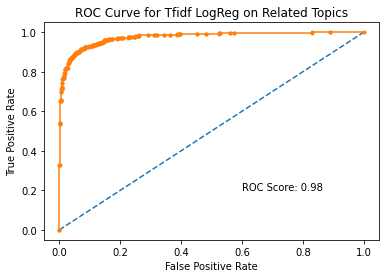

In [158]:
plot_roc_curve(model_2, X_dl, y_dl,
               title='ROC Curve for Tfidf LogReg on Related Topics')

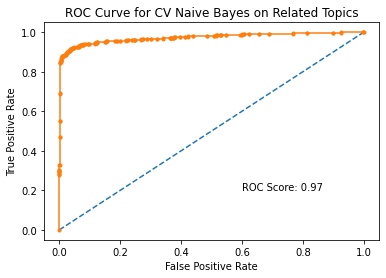

In [159]:
plot_roc_curve(model_3, X_dl, y_dl,
               title='ROC Curve for CV Naive Bayes on Related Topics')

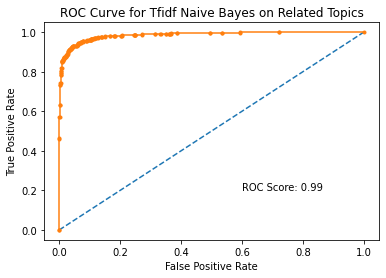

In [160]:
plot_roc_curve(model_4, X_dl, y_dl,
               title='ROC Curve for Tfidf Naive Bayes on Related Topics')

The Tfidf Naive Bayes Model (model 4) has a higher score than the Count Vectorizer Naive Bayes Model (model 3) and the Tfidf Logistic Regression Model (model 2), but all three models have extremely close scores. The best score was 0.99. These scores are evaluated on the related topic data. This shows that the model can generalise to unseen data of adjacent topics, and that the model is capable of distinguishing between these classes effectively. 

In [161]:
print(classification_report(y_dl, model_2.predict(X_dl)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       861
           1       0.95      0.89      0.92       940

    accuracy                           0.92      1801
   macro avg       0.92      0.92      0.92      1801
weighted avg       0.92      0.92      0.92      1801



In [162]:
print(classification_report(y_dl, model_3.predict(X_dl)))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       861
           1       0.99      0.87      0.93       940

    accuracy                           0.93      1801
   macro avg       0.93      0.93      0.93      1801
weighted avg       0.94      0.93      0.93      1801



In [163]:
print(classification_report(y_dl, model_4.predict(X_dl)))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       861
           1       0.94      0.94      0.94       940

    accuracy                           0.94      1801
   macro avg       0.94      0.94      0.94      1801
weighted avg       0.94      0.94      0.94      1801



Taking a closer look at the detailed classification reports of models 2-4 show us that they differ in their ability to comprehensively or precisely capture the positive and negative classes.

For instance, model 3 has the best precision with the positive class and best recall with the negative class, but does the worst of the 3 for recall on the positive class. This means that it performed the worst in capturing all the positive examples (deep learning) in the related topic set.

In general, although model 4 does not outperform the other models on individual precision and recall metrics for both the negative and positive label, it has the best f1-scores overall because its performance on all the metrics are overall more balanced and consistently high across the different metrics and classes. As for this task, since it is both important to identify content actually about natural language processing/deep learning and also to filter out content about neuro linguistic programming, a model with a more consistent performance on both classes' fronts is more desirable.

### Interpreting Feature Selection of Best Models

To better understand the good performance of the NB models (model_3, model_4) and the Logistic Regression Tfidf model (model_2), the feature importances of these models will be analysed.

In [164]:
get_feature_scores(model_2)

{'tal state': 22.46706652994162,
 'taught': 18.45078747923615,
 'import': 10.129880475050593,
 'cy': 8.86558547954498,
 'bash': 8.391252487438773,
 'model question': 7.5192377755537105,
 'dont': 6.736122335869252,
 'ori': 6.237244524744945,
 'pay att': 5.892106774249803,
 'managed': 5.667968761458337,
 'appreciate it': 5.4971979862144424,
 'movem': 5.493191364763877,
 'description': 4.72232167362157,
 'giv': 4.60183455187465,
 'associate': 4.524835173098711,
 'would helpful': 4.288056318279742,
 'techniques used': 4.278357579154733,
 'anyone': 3.9954095082718837,
 'gpus': 3.9338860748161366,
 'anything': 3.7605122723320403,
 'hold': 3.6863199300234735,
 'help out': 3.5479203163674766,
 'hang': 3.218506696942786,
 'while': 3.21137638307645,
 'pip install': 3.165893760503456,
 'conflict': 3.141370800770972,
 'says': 3.124476505209685,
 'find answer': 3.09835350621622,
 'summit': 2.948528821058937,
 'sound': 2.892054492420774,
 'perfect': 2.8850707826476745,
 'hurt': 2.874371218792244,
 '

In [165]:
get_feature_scores(model_3)

{'control tabl': 0.006853401491387033,
 'laughs': 0.006610959722940027,
 'answer someth': -0.005497307517016702,
 'research team': 0.005284062892327886,
 'without code': 0.004746889136103169,
 'word repr': 0.004576384582668077,
 'running': 0.004565497265219893,
 'actual go': 0.004518448404978532,
 'chat': 0.004308095134070148,
 'rpc': 0.0031680271442457103,
 'tok order': 0.003084816741211172,
 'becaus': 0.0030381564270721183,
 'john snow': -0.002778409641669203,
 'along': -0.0026800352385332443,
 'that happ': 0.002612773954388339,
 'know tool': -0.002606932385214412,
 'like this': -0.002539467463670824,
 'formul': -0.0025361634840372843,
 'alignm': 0.002485234513828589,
 'project onto': 0.0024850496051249714,
 'qualif': 0.002451211312362031,
 'max gth': 0.0024344931278513834,
 'rare': -0.0024020187597383193,
 'python': 0.0023889984520192482,
 'schedul': 0.002369750704551806,
 'sever': -0.002337083401151523,
 'kera': -0.0023339723568052053,
 'domain abl': 0.0023230903904127524,
 'use se

In [166]:
get_feature_scores(model_4)

{'answer someth': -0.002492068301433774,
 'control tabl': 0.0014276859260246733,
 'without code': 0.001374452876770179,
 'alignm': 0.0011376001703257582,
 'actual go': 0.0010580084035463487,
 'schedul': 0.0009578191339627622,
 'qualif': 0.0008708457249824087,
 'along': -0.0008439014306213211,
 'max gth': 0.000759603186856061,
 'project onto': 0.0007162955961191045,
 'becaus': 0.0007087648149156139,
 'domain abl': 0.0007084125144091826,
 'tok order': 0.0007068473096124685,
 'fuell': 0.0006916166373863361,
 'chat': 0.0006911521992583047,
 'record': -0.0006709298220158653,
 'sort information': -0.0006602871093293443,
 'rare': -0.0006305031654683865,
 'want do': -0.00062093299841378,
 'python': 0.0006093027398819546,
 'littl experi': -0.0006064875487128446,
 'convert text': 0.0006064854900355395,
 'two': 0.0005970679052184572,
 'nlp technique': 0.0005966295517289448,
 'book suggest': -0.000592831280872775,
 'factual': 0.0005898575335488433,
 'sever': -0.000580426716483763,
 'hypnot': -0.00

In [167]:
[t for t in df['content'] if 'control' in t.lower() and 'tabl' in t.lower()]

["Who regulates NLP in the UK?   \n\nI have cause for concern regarding the toxic side of the self-development industry, its marketing towards children, families with sick children, and children with mental health problems. It’s application for ‘self-development’ that is being targeted towards children, as well as its use to treat medical conditions in children by those with no medical training or education; and alarmingly its encroachment into the school and classroom environments for both.\n\nMy hope is that this email will start a conversation with those who are best equipped to have it, so that the right action can be taken to ensure the welfare of all children.\n\nThere are a lot of people in this world selling snake oil, “cure all’s”, one in particular is N.L.P. \n\nN.L.P. is part of the self-development industry which is estimated to be worth globally $15 billion with nearly 6% average yearly gains. To put it lightly, people are making serious money from self-development. The se

The 'contrl tabl' feature in the naive bayes coefficients seems to come from Google AI's ToTTo: A Controlled Table-to-Text Generation Dataset. While this makes sense as a feature that can characterises the natural language processing topic, it is weird that it features so heavily against the other features as this feature is not going to always appear in language technology content as it is a very particular example of a subtopic.  

The top weighted coefficients for the logistic regression model and the naive models are quite different. Although this is not surprising due to a huge amount of features, it is also worrying that there are no strong insights as to obvious features that distinguish the two classes. 

In terms of interpretability, this is a strong drawback, and there are no obvious insights into important terms that can effectively distinguish the topics. On the other hand, perhaps it is precisely that the models' strengths in classifying effectively comes from the **combination of many features** that is not easily visible when one simply looks at the top coefficients.

## Analyse Wrongly Classified Posts

In this section, the best model's (model 4) features will be analysed to see if trimming any misleading features can improve performance.

The features with the highest cumulative tfidf scores in the misclassified examples of the model relative to the scores of all the examples will be examined. The assumption being that these features are likely to be the features that misleads the model.

There will be some discussion of these features. And some of these top features will be removed to see if doing so can improve model accuracy.

In [168]:
def get_incorrect_samples(model, predictors=X_test.values, targets=y_test.values):
    """
    Returns a new dataframe of all the texts where actual != predicted.
    """
    incorrect_df = pd.DataFrame(predictors, columns=['text'])
    incorrect_df['actual'] = targets
    incorrect_df['predicted'] = model.predict(predictors)
    
    incorrect_df['og_index'] = incorrect_df.index
    
    
    incorrect = incorrect_df[incorrect_df['actual'] != incorrect_df['predicted']]
    incorrect = incorrect.reset_index(drop='True')
    return incorrect

In [169]:
def get_frequent_misclassed_features(model, predictors=X_test.values, targets=y_test.values, reverse=True):
    """
    Returns text features of misclassified examples
    if they are present in the model, ranked by their 
    cumulative feature scores in the misclassified data
    as a proportion of the cumulative feature scores in
    the total data.
    """
    incorrect_predictions = get_incorrect_samples(model, predictors, targets)
    incorrect_predictions_text = incorrect_predictions['text']
    ic_model_term_matrix = model[0].transform(incorrect_predictions_text)
    total_model_term_matrix = model[0].transform(predictors)
    ic_model_t_m_summed = ic_model_term_matrix.sum(axis=0)
    total_model_t_m_summed = total_model_term_matrix.sum(axis=0)
    
    ic_model_t_m_summed.resize(ic_model_t_m_summed.shape[1],)
    total_model_t_m_summed.resize(total_model_t_m_summed.shape[1],)
    # add 1 to scores to prevent zero division errors
    total_model_scores = np.add(total_model_t_m_summed, (np.ones(total_model_t_m_summed.shape),))
    
    summed_score_proportions = ic_model_t_m_summed / total_model_scores
    summed_score_proportions.resize(summed_score_proportions.shape[1],)
    return dict(sorted(zip(model[0].vocabulary_, summed_score_proportions),key=lambda x:x[1], reverse=reverse))

In [170]:
m4_miscl_features = get_frequent_misclassed_features(model_4, X_dl.values, y_dl.values)

In [171]:
m4_miscl_features

{'ha': 0.44093458909729927,
 'start make': 0.4327824831429995,
 'ce model': 0.3879057122412223,
 'best knowledge': 0.3852385989563146,
 'intrus': 0.3779704559424049,
 'properly': 0.3774851805205872,
 'around lot': 0.3747293397298133,
 'reg': 0.3549978483626867,
 'work best': 0.34982869538374556,
 'hidd': 0.3479670611650218,
 'rpc': 0.34764653286088265,
 'th turi': 0.3441566853825062,
 'member ev': 0.3304330263182701,
 'erget': 0.3301048942270919,
 'nxivm': 0.32728754616191275,
 'like these': 0.3267024979804952,
 'categor': 0.31466877564411677,
 'model rec': 0.31416920844148755,
 'form': 0.30648638660359845,
 'everyth': 0.28346265577088225,
 'dollar': 0.2832784906229598,
 'taught': 0.28298440821272053,
 'child': 0.2775761142206541,
 'immedi': 0.27018088015681213,
 'intermedi': 0.26729370271928116,
 'ce ce': 0.26427446678934446,
 'seldom': 0.26427446678934446,
 'drama': 0.26427446678934446,
 'model success': 0.2606268349340258,
 'much info': 0.2585523842946256,
 'deviat': 0.2581893078135

In [172]:
m4_miscl_features_20 = list(m4_miscl_features.keys())[:20]

In [173]:
def preproc_rm_features(raw_text, features_to_remove=m4_miscl_features_20):
    processed = re.sub(r'\n|\t', ' ', raw_text)
    processed = melt_urls(clean_sqb(processed))
    processed = re.sub(r'\d+', '', processed)
    processed = processed.lower()
    processed = remove_stopwords(processed)
    processed = stem(processed) 
    for ft in features_to_remove:
        processed = processed.replace(ft, ' ')
    return processed

In [174]:
model_4_rm = Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 preprocessor=preproc_rm_features)),
                ('nb', MultinomialNB(fit_prior=False))])

In [175]:
model_4_rm.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function preproc_rm_features at 0x7fc2cc71f280>)),
                ('nb', MultinomialNB(fit_prior=False))])

In [176]:
model_4_rm.score(X_train, y_train)

0.9858520900321543

In [177]:
model_4_rm.score(X_test, y_test)

0.9485861182519281

In [178]:
model_4_rm.score(X_dl, y_dl)

0.9389228206551916

In [179]:
# compare to original model performance
# results.iloc[3,:]

Removing the top 20 highest tfidf scoring features of the misclassified data from the model seems to slightly improve the train accuracy and related topic accuracy at the expense of the test accuracy. There does not seem to be significant benefit from the added complexity of calculating the top features in the misclassified data and filtering them out from the models after.

## Conclusion

1. The best model for prediction is multinomial naive bayes classifier with tifidf vectorizer, and it has proven to generalise well to distinguishing adjacent topics too. This shows promise that the classifier has the potential to learn from a wider range of natural language processing topics to be able to classify beyond the limited language technology reddit subset of vocabulary it has trained on.


2. Separating neuro-linguistic programming content from natural language processing content appears to be a very achievable task, however, the highest weighted features of the best models are slightly worrying in that they do not seem to be words that very obviously distinguish the two classes. (might not be a bad thing, that is why we have ML). More work can definitely be done to improve the model to be ready for a wider range of natural language processing topics. Moving forward, it would be helpful scrape a larger variety of training data that covers a wider range of vocabulary for both topics. 


3. Although the intuition is that the two topics can be separated by a few obvious terms, the model performance and coefficients indicate that better prediction comes from learning from a wider variety of features.